### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #08

#### Name:

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy

## Preparation: Load data

In [2]:
fname = 'imagVPaw.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Implement Common Spatial Pattern (CSP) Analysis  (4 points)
Implement a function for performing a common spatial pattern (CSP) analysis of two-class input data.

In [5]:
def train_CSP(epo, mrk_class):
    ''' 
    Usage:
        W, d = trainCSP(epo, mrk_class)
    Parameters:
        epo:   a 3D array of segmented signals (samples x channels x epochs)
        mrk_class: a 1D array that assigns markers to classes (0, 1)
    Returns:
        W:     matrix of spatial filters
        d:     vector of generalized Eigenvalues
    '''
    target = epo[:, :, mrk_class == 0].transpose(2,0,1).reshape(-1, epo.shape[1]).T
    nontarget = epo[:, :, mrk_class == 1].transpose(2,0,1).reshape(-1, epo.shape[1]).T
    
    # A= cov_class_1
    # B = cov_class_1 + cov_class_2
    A = np.cov(target)
    B = np.cov(nontarget)
    B = A + B 
    
    #conduct generalized eigenvector decomposition
    d, W = sp.linalg.eigh(A, B)
    return W, d

## Exercise 2: Perform CSP Analysis on Motor Imagery Data  (3 points)
Apply a band-pass filter to the given (continuous) EEG signals with pass-band [10.5 13.] Hz, or use your findings of exercises \#1 on the last sheet to define the frequency band. Perform a CSP analysis for the time interval 750-4000 ms.
Plot the generalized Eigenvalues corresponding to both classes in one plot and select the 6 CSP filters for which the best discrimination can be expected according to the Eigenvalues. Apply the six spatial filters to the band-pass filtered EEG signals. The resulting signals are subsequently called CSP-filtered signals.

Xf shape: (51, 282838)
Epo shape: (326, 51, 280)
d shape: (51,)
W shape: (51, 51)


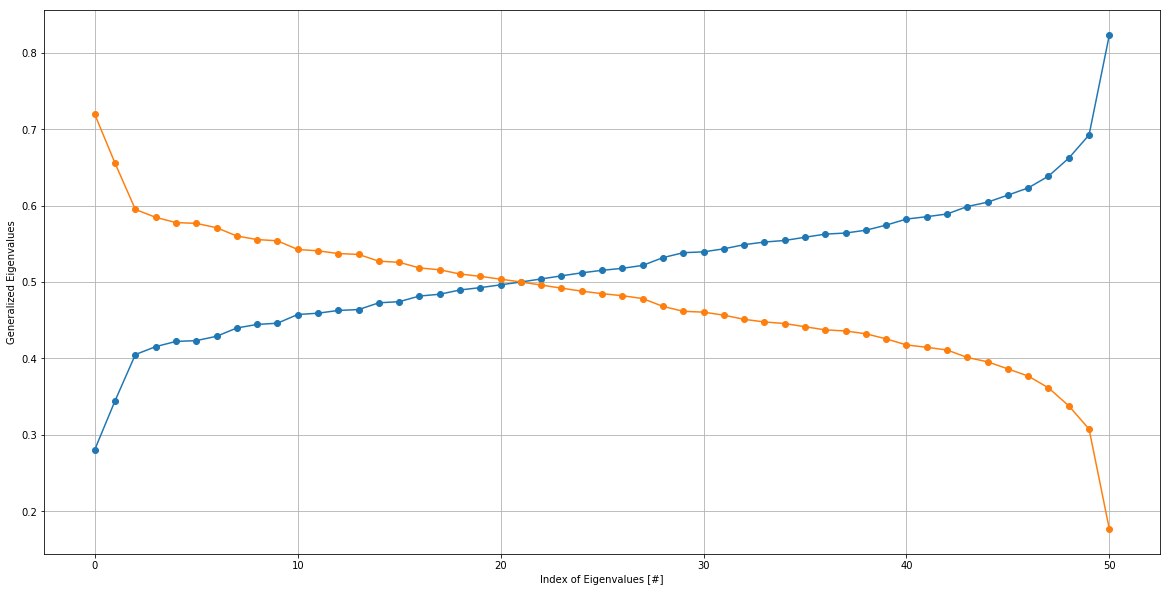

In [6]:
ival = [750, 4000]

ws = fs*2*np.pi
band = [((10.5*2*np.pi)/(.5*ws)), ((13.0*2*np.pi)/(.5*ws))]
b, a = sp.signal.butter(5, band, btype="bandpass")
Xf = sp.signal.lfilter(b,a,cnt)

epo, epo_t = bci.makeepochs(Xf, fs, mrk_pos, ival)

#Debugging
print("Xf shape:", Xf.shape)
print("Epo shape:", epo.shape)

W, d = train_CSP(epo, mrk_class)
print("d shape:", d.shape)
print("W shape:", W.shape)

plt.figure(figsize=(20,10))
plt.plot(d, "-o")
#1-d: lecture 9 slide 16
plt.plot(1-d, "-o")
plt.grid()
plt.xlabel('Index of Eigenvalues [#]')
plt.ylabel('Generalized Eigenvalues')

#Best 6 filters: the 3 ones on the left and 3 ones on the right side of the graph.
#choose 6 spatial filters from the CSP 
W_6 = W[:, [-1, -2, -3, 0, 1, 2]]
source_filtered = W_6.T.dot(Xf)
#CSP_filtered is CSP-filtered signals. 
#CSP_filtered = W_6.dot(source)

## Exercise 3:  Visualizing of CSP Patterns and ERD Curves  (4 points)
Visualize the six spatial patterns corresponding to the CSP filters as topographies. (If you did not succeed with exercise \#1 or \#2, download the file `imagVPaw_csp}` from the course page, which includes the full filter matrix $\bf W$ and Eigenvalues $\bf d$).
Take the CSP-filtered signals and visualize the classwise averaged ERD/ERS curves in the 6 channels.
Use the time interval from -500 ms to 6000 ms. Determine from these curves a time interval which shows a good discrimination of between the two motor imagery conditions for subsequent tasks.
**Note:** It would be better to use $r^2$-values for this purpose, but we skip that for this exercise.

erd0 shape :  (651, 6)
erd1 shape :  (651, 6)
Using our eagle-eyes, we determine that from 1000 to 4000 ms is the best for discrimation. 


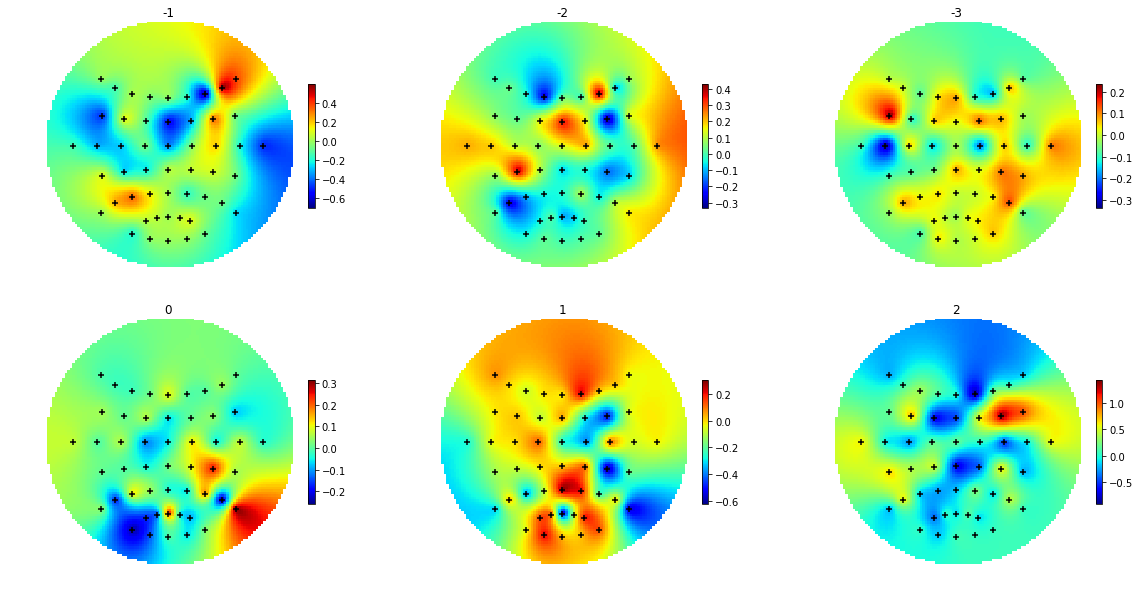

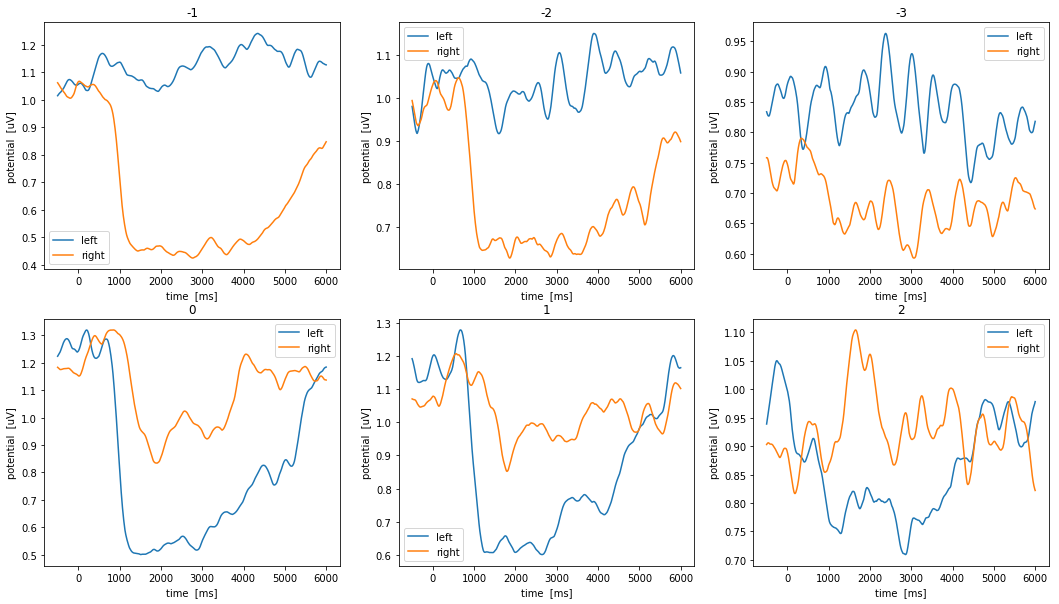

In [7]:
ival = [-500, 6000]
eigen = [-1, -2, -3, 0, 1, 2]

#Plot six spatial patterns of CSP filters.
plt.figure(figsize = (20, 10))
for i in range(6):
    plt.subplot(2,3, i+1)
    bci.scalpmap(mnt, W[eigen[i]])
    plt.title(eigen[i])

#hilbert transformation
cnt_hill = np.abs(sp.signal.hilbert(source_filtered, axis=1))

erd, erd_t = bci.makeepochs(cnt_hill, fs, mrk_pos, ival)

#ERD curve
erd0 = np.mean(erd[:,:,mrk_class==0], axis=2)
erd1 = np.mean(erd[:,:,mrk_class==1], axis=2)
print("erd0 shape : ", erd0.shape)
print("erd1 shape : ", erd1.shape)

plt.figure(figsize=[18, 10])
nChans= len(eigen)
for i in range(nChans):
    plt.subplot(2, nChans/2, i+1)
    plt.plot(erd_t, erd0[:, i], label=mrk_className[0])
    plt.plot(erd_t, erd1[:, i], label=mrk_className[1])
    plt.title(eigen[i])
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')
    plt.legend()
    
print("Using our eagle-eyes, we determine that from 1000 to 4000 ms is the best for discrimation. ")

## Exercise 4: Visualization of log band-power Features  (4 points)
Take the CSP-filtered signals, extract single trials in the time interval determined in exercise \#3 (or 750-4000 ms if you did not succeed) and calculate the log variance within each trial. Make a figure with six subplots, in which for each CSP-channel, the log band-power values are shown (trials on $x$-axis, log bp on $y$ axis).
Calculate the signed r^2-values for each of the six features and add them as title of the subplots. 
Determine log band-power values for each trial and channel (without CSP filter), calculate the r^2-values for each channel and display the result as topography.

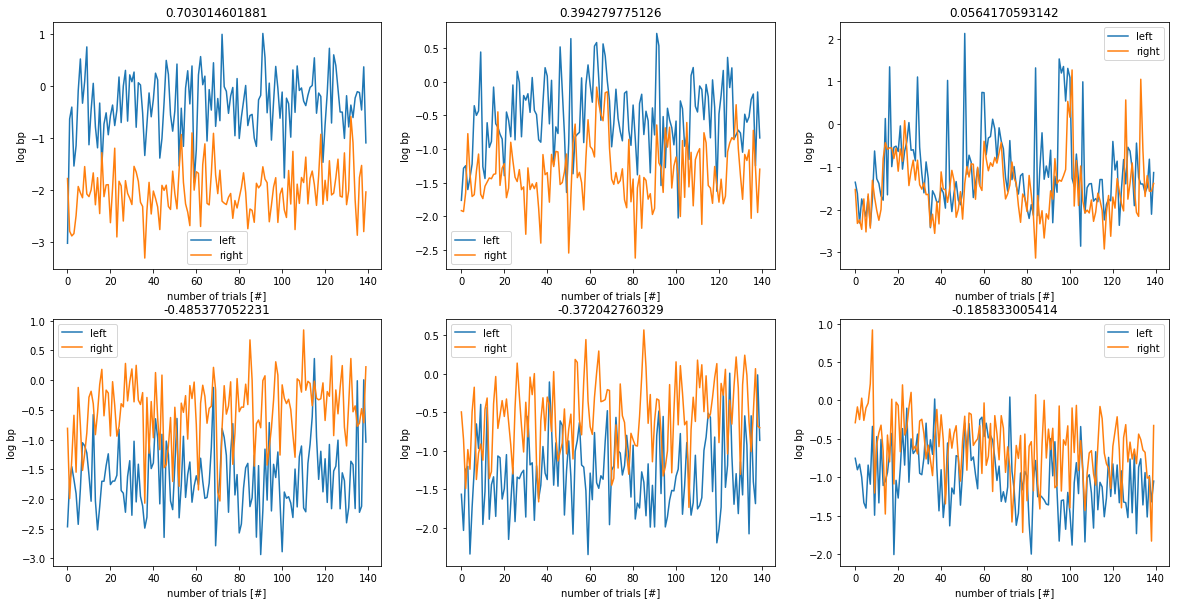

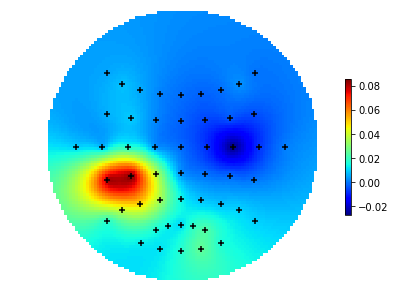

In [8]:
log_erd, log_erd_t =  bci.makeepochs(source_filtered, fs, mrk_pos, [1000, 4000])

plt.figure(figsize = (20, 10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    #log band power calculation for class 0
    f = log_erd[:, i, mrk_class == 0]
    f = np.log(np.var(f, axis = 0))
    plt.plot(f, label = mrk_className[0])
    
    #log band power calculation for class 1
    s = log_erd[:, i, mrk_class == 1]
    s= np.log(np.var(s, axis = 0))
    plt.plot(s, label = mrk_className[1])
    
    #Calculate signed R^2-values
    mean0 = np.mean(f)
    mean1 = np.mean(s)
    var = np.var(np.append(f, s))
    
    #both class has the same number of trials. So the calculation within each class number is simplified as value 0.25.
    R = 0.25 *((mean0-mean1)**2/var)*np.sign(mean0-mean1)
    plt.title(R)
    
    plt.xlabel("number of trials [#]")
    plt.ylabel("log bp")
    plt.legend()
    
plt.figure(figsize=(10, 5))
epo, epo_t = bci.makeepochs(Xf, fs, mrk_pos, [1000, 4000])
var = np.var(epo, axis =0)
logvar = np.log(var)

channel_r = np.zeros(51)

for i in range(51):
    mean0 = np.mean(var[i, mrk_class==0])
    mean1 = np.mean(var[i, mrk_class==1])
    variance = np.var(var[i, :])
    
    r = 0.25*((mean0-mean1)**2/variance) *np.sign(mean0-mean1)
    channel_r[i] = r
    
bci.scalpmap(mnt, channel_r)